<a href="https://colab.research.google.com/github/Vizzuality/copernicus-climate-data/blob/master/prepare_eu_nuts_lau_geometries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare data for the copernicus climate project

https://github.com/Vizzuality/copernicus-climate-data

`Edward P. Morris (vizzuality.)`

## Description
This notebook creates an xarray dataset of geometries and properties using the NUTS 2016 and LAU 2018 classification. NUTS (Nomenclature of Territorial Units for Statistics) is a European Union standard for referencing the subdivisions of countries (member states, candidate countries and EFTA countries), whereas the Local Administrative Units (LAU) LAU classification is not covered by any legislative act. The datasets are exported as cloud optimised ZARR ready for use in further processing.

```
MIT License

Copyright (c) 2020 Vizzuality

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

# Setup

## Linux dependencies

In [1]:
# Packages for projections and geospatial processing
!apt install -q -y libspatialindex-dev libproj-dev proj-data proj-bin libgeos-dev

Reading package lists...
Building dependency tree...
Reading state information...
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev libproj-dev libspatialindex-c4v5 libspatialindex-dev
  libspatialindex4v5 proj-bin
0 upgraded, 6 newly installed, 0 to remove and 25 not upgraded.
Need to get 860 kB of archives.
After this operation, 5,014 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4

## Python packages

In [2]:
!pip install -q country-converter geos cftime netcdf4 zarr xarray xclim gcsfs nc-time-axis rioxarray geopandas regionmask sparse --upgrade #dask distributed 

     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 368kB 13.9MB/s 
     |████████████████████████████████| 337kB 48.0MB/s 
     |████████████████████████████████| 4.1MB 51.9MB/s 
     |████████████████████████████████| 3.3MB 36.2MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 3.7MB 40.6MB/s 
     |████████████████████████████████| 931kB 40.4MB/s 
     |████████████████████████████████| 122kB 51.4MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 3.8MB 46.7MB/s 
     |████████████████████████████████| 174kB 45.2MB/s 
     |████████████████████████████████| 10.4MB 23.8MB/s 
     |████████████████████████████████| 194kB 56.2MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 14.7MB 164kB/s 
     |████████████████████████████████| 18.1MB 234kB/s 
     |████████████████████████████████| 8.9MB 23.5MB/

In [3]:
!pip list

Package                  Version        
------------------------ ---------------
absl-py                  0.9.0          
affine                   2.3.0          
alabaster                0.7.12         
albumentations           0.1.12         
altair                   4.1.0          
asciitree                0.3.3          
asgiref                  3.2.7          
astor                    0.8.1          
astropy                  4.0.1.post1    
astunparse               1.6.3          
atari-py                 0.2.6          
atomicwrites             1.3.0          
attrs                    19.3.0         
audioread                2.1.8          
autograd                 1.3            
Babel                    2.8.0          
backcall                 0.1.0          
beautifulsoup4           4.6.3          
bleach                   3.1.4          
blis                     0.4.1          
bokeh                    1.4.0          
boltons                  20.1.0         
boto3           

In [4]:
# Set options
%matplotlib inline
# Set xarray options
import xarray as xr
xr.set_options(display_style='html', display_width=80, warn_for_unclosed_files=True, keep_attrs=False)



## Authorisation

In [0]:
# For auth WITHOUT service account
#from google.colab import auth
#auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
#project_id = "skydipper-196010"
#!gcloud config set project {project_id}

In [0]:
# Copy GC credentials to home (place in your GDrive, and mount Drive)
!cp "/content/drive/My Drive/skydipper-196010-f842645fd0f3.json" "/root/.skydipper-196010-f842645fd0f3.json"

In [7]:
# Auth WITH service account
!gcloud auth activate-service-account \
  edward-morris@skydipper-196010.iam.gserviceaccount.com \
          --key-file=/root/.skydipper-196010-f842645fd0f3.json --project="skydipper-196010"


Activated service account credentials for: [edward-morris@skydipper-196010.iam.gserviceaccount.com]


In [8]:
# Test GC auth
!gsutil ls "gs://copernicus-climate"

gs://copernicus-climate/coldspells_historical.zip
gs://copernicus-climate/coldspells_longterm.zip
gs://copernicus-climate/heatwave_seasonal.zip
gs://copernicus-climate/heatwaves_historical.zip
gs://copernicus-climate/heatwaves_longterm.zip
gs://copernicus-climate/pet_woman_lying_2005-2019.zip
gs://copernicus-climate/pet_woman_walking_2005-2019.zip
gs://copernicus-climate/spain.zarr.zip
gs://copernicus-climate/tasmax_historical.zip
gs://copernicus-climate/tasmax_longterm_decadal.zip
gs://copernicus-climate/tasmin_historical.zip
gs://copernicus-climate/tasmin_longterm_decadal.zip
gs://copernicus-climate/tmax_seasonal_monthly.zip
gs://copernicus-climate/tmin_seasonal_monthly.zip
gs://copernicus-climate/variables_futuro_CMIP5_AEMET.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_1.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_2.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_3.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_4.zip
gs://coper

In [0]:
# Clean up
!rm -r sample_data

## Dask

In [0]:
# FIXME: Old dask version in CoLab, update causes crashes!
#from distributed import Client

# Depending on your workstation specifications, you may need to adjust these values.
# On a single machine, n_workers=1 is usually better.
# n_workers=1, threads_per_worker=4, memory_limit="4GB"
#Client(processes=False, diagnostic_port=None)
#client


# Utils

## download_url

In [0]:
import requests

def download_url(url, save_path, chunk_size=512):
  """ Download from url and save to file
  """
  r = requests.get(url, stream=True)
  with open(save_path, 'wb') as fd:
      for chunk in r.iter_content(chunk_size=chunk_size):
          fd.write(chunk)

## mkdirs

In [0]:
from pathlib import Path

def mkdirs(dirs_list, exist_ok=True):
  """ Create nested directories
  """
  for p in dirs_list:
    Path(p).mkdir(parents=True, exist_ok=exist_ok)


## gdf_to_xarray

In [0]:
import shapely

def gdf_to_xarray(gdf, coords, dims, chunk, attrs):
  
  # Convert geoms to WKT binary hex 
  geoms = gdf.apply(lambda x: shapely.wkb.dumps(x.geometry, hex=True), axis=1)
  gdf.loc[:,'geometry'] = geoms

  # Set multiindex
  gdf = gdf.set_index(dims)

  # Convert to xarray
  gda = gdf.to_xarray()

  # Set coords
  gda = gda.set_coords(coords)

  # Set attributes
  gda = gda.assign_attrs(attrs)
  
  return gda.chunk(chunk)
 

## write_to_remote_zarr

In [0]:
import gcsfs
import zarr
import xarray as xr

def write_to_remote_zarr(
    ds,
    group,
    root,
    project_id = "skydipper-196010",
    token="/root/.skydipper-196010-f842645fd0f3.json"
    ):
  
  # Connect to GS
  gc = gcsfs.GCSFileSystem(project=project_id, token=token)
  store = gc.get_mapper(root, check=False, create=True)
  
  # Write to zarr group
  ds.to_zarr(store=store, group=group, mode="w", consolidated=True)
  # consolidate metadata at root
  zarr.consolidate_metadata(store)
  c = gc.exists(f"{root}/.zmetadata")
  print(f"{root} is consoldiated? {c}")
  with zarr.open(store, mode='r') as z:
    print(z.tree())



## get_cached_remote_zarr

In [0]:
import gcsfs
import zarr
import xarray as xr



def get_cached_remote_zarr(
    group,
    root,
    project_id = "skydipper-196010",
    token="/root/.skydipper-196010-f842645fd0f3.json"
    ):
  
  # Connect to GS
  gc = gcsfs.GCSFileSystem(project=project_id, token=token)
  store = gc.get_mapper(root, check=False, create=False)
  # Check zarr is consolidated
  consolidated = gc.exists(f'{root}/.zmetadata')
  # Cache the zarr store
  #store = zarr.ZipStore(store, mode='r')
  cache = zarr.LRUStoreCache(store, max_size=None)
  # Return cached zarr group
  return xr.open_zarr(cache, group=group, consolidated=consolidated)

## get_gda_geoms

In [0]:
import geopandas as gpd
import shapely

def get_gda_geoms(group, select_by=None, root = "copernicus-climate/european-nuts-lau-geometries.zarr"):
  gda = get_cached_remote_zarr(group, root = root)
  # Select
  if select_by:
    gda = gda.sel(select_by, drop=True)
  df = gda.reset_coords().to_dataframe().dropna().reset_index()
  geoms = gda.geometry.map(lambda g: shapely.wkb.dumps(g, hex=True))
  # Return as geopandas object, converting geometry to shapley objects
  return gpd.GeoDataFrame(df, geometry=[shapely.wkb.loads(g, True) for g in geoms])


# Process data

### Setup directory structure

In [0]:
# Define paths
ds_dir = "dataset"
gs_prefix ="gs://copernicus-climate"
dirs_list = [f"{ds_dir}"]
#dirs_list = [f"{ds_dir}/ref-nuts-2016-01m", f"{ds_dir}/ref-nuts-2016-01m"]            

In [16]:
# Start with a clean structure
!rm -r {ds_dir}

rm: cannot remove 'dataset': No such file or directory


In [0]:
# Make directory structure
mkdirs(dirs_list, exist_ok=True)

## Get NUTS 2016 classification from GISCO API

In [0]:
# Download
url = 'https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/download/ref-nuts-2016-01m.gdb.zip'
fn = 'ref-nuts-2016-01m.gdb.zip'
download_url(url, fn)

In [0]:
# Extract
import zipfile
with zipfile.ZipFile(fn, 'r') as zip_ref:
    zip_ref.extractall(f"{ds_dir}")

## Get LAU 2018 classification from GISCO API

In [0]:
url ="https://ec.europa.eu/eurostat/cache/GISCO/geodatafiles/LAU-2018-01M-SH.zip"
fn = 'LAU-2018-01M-SH.zip'
download_url(url, fn)

In [0]:
# Extract
import zipfile
with zipfile.ZipFile(fn, 'r') as zip_ref:
    zip_ref.extractall(f"{ds_dir}")

## Combine NUTS and LAU

### Load geometries

In [7]:
ds_dir = "dataset"
import geopandas as gpd
# Load the geometries
p = f"{ds_dir}/LAU_2018.shp"
gdf_lau = gpd.read_file(p).to_crs("EPSG:4326").set_index('GISCO_ID', drop=False)
gdf_lau.head()

,LAU_CODE,LAU_LABEL,GISCO_ID,Shape_Leng,Shape_Area,geometry
GISCO_ID,,,,,,
IS_0000,0000,Reykjavíkurborg,IS_0000,2.834724,0.050734,"MULTIPOLYGON (((-21.58641 64.01809, -21.56910 ..."
HR_00019,00019,Andrijaševci,HR_00019,0.279030,0.004518,"POLYGON ((18.76285 45.21731, 18.76666 45.21115..."
HR_00027,00027,Antunovac,HR_00027,0.430671,0.006581,"POLYGON ((18.60095 45.46151, 18.62168 45.50965..."
HR_00035,00035,Babina Greda,HR_00035,0.466454,0.009074,"POLYGON ((18.48985 45.12331, 18.50029 45.12919..."
HR_00043,00043,Bakar,HR_00043,0.665660,0.014395,"POLYGON ((14.55529 45.28892, 14.53287 45.29944..."


In [8]:
import geopandas as gpd
# Load the geometries
p = f"{ds_dir}/ref-nuts-2016-01m.gdb"
gdf_nuts = gpd.read_file(p).to_crs("EPSG:4326").set_index('NUTS_ID', drop=False)
gdf_nuts.head()

,LEVL_CODE,NUTS_ID,CNTR_CODE,NAME_LATN,NUTS_NAME,NAME_ASCI,NAME_HTML,NAME_ENGL,NAME_FREN,ISO3_CODE,SVRG_UN,CAPT,EU_STAT,EFTA_STAT,CC_STAT,NAME_GERM,Shape_Length,Shape_Area,geometry
NUTS_ID,,,,,,,,,,,,,,,,,,,
AL,0,AL,AL,SHQIPËRIA,SHQIPËRIA,SHQIPERIA,SHQIP&#x00CB;RIA,Albania,Albanie,ALB,UN Member State,Tirana,F,F,T,Albanien,1.095201e+06,2.879967e+10,"MULTIPOLYGON (((19.75628 42.63384, 19.75005 42..."
CZ,0,CZ,CZ,ČESKÁ REPUBLIKA,ČESKÁ REPUBLIKA,CESKA REPUBLIKA,&#x010C;ESK&#x00C1; REPUBLIKA,Czechia,Tchéquie,CZE,UN Member State,Prague,T,F,F,Tschechien,2.004498e+06,7.887326e+10,"MULTIPOLYGON (((14.33499 51.04007, 14.34494 51..."
DE,0,DE,DE,DEUTSCHLAND,DEUTSCHLAND,DEUTSCHLAND,DEUTSCHLAND,Germany,Allemagne,DEU,UN Member State,Berlin,T,F,F,Deutschland,6.420996e+06,3.576614e+11,"MULTIPOLYGON (((10.45102 47.55460, 10.45444 47..."
DK,0,DK,DK,DANMARK,DANMARK,DANMARK,DANMARK,Denmark,Danemark,DNK,UN Member State,Copenhagen,T,F,F,Dänemark,6.087023e+06,4.317145e+10,"MULTIPOLYGON (((10.03972 57.06014, 10.05748 57..."
CY,0,CY,CY,KYPROS,ΚΥΠΡΟΣ,KYPROS,KYPROS,Cyprus,Chypre,CYP,UN Member State,Nicosia,T,F,F,Zypern,6.491417e+05,9.256703e+09,"MULTIPOLYGON (((34.58451 35.69436, 34.57359 35..."


In [0]:
# Get conversion table between NUTS_ID countries and ISO3_CODE
id_to_iso3 = gdf_nuts.loc[gdf_nuts['LEVL_CODE'] == 0,['NUTS_ID', 'ISO3_CODE']]

### Prepare data frames

In [10]:
# Prepare LAU
nid = [s.split('_')[0] for s in gdf_lau.loc[:,'GISCO_ID'].values.tolist()]
gdf_lau.loc[:,'iso3'] = nid
gdf_lau = gdf_lau.reset_index(drop=True).set_index('iso3', drop=False)
gdf_lau = gdf_lau.replace(id_to_iso3.NUTS_ID.values.tolist(), id_to_iso3.ISO3_CODE.values.tolist())
gdf_lau = gdf_lau.reset_index(drop=True)
gdf_lau = gdf_lau.rename({'LAU_LABEL':'geoname', 'GISCO_ID':'gid'}, axis=1)
gdf_lau.loc[:,'admin_level'] = 4
gdf_lau = gdf_lau[['admin_level','iso3','gid','geoname','geometry']]
gdf_lau

,admin_level,iso3,gid,geoname,geometry
0,4,ISL,IS_0000,Reykjavíkurborg,"MULTIPOLYGON (((-21.58641 64.01809, -21.56910 ..."
1,4,HRV,HR_00019,Andrijaševci,"POLYGON ((18.76285 45.21731, 18.76666 45.21115..."
2,4,HRV,HR_00027,Antunovac,"POLYGON ((18.60095 45.46151, 18.62168 45.50965..."
3,4,HRV,HR_00035,Babina Greda,"POLYGON ((18.48985 45.12331, 18.50029 45.12919..."
4,4,HRV,HR_00043,Bakar,"POLYGON ((14.55529 45.28892, 14.53287 45.29944..."
...,...,...,...,...,...
102547,4,GBR,UK_W06000020,Torfaen,"POLYGON ((-2.95821 51.62899, -2.96307 51.62530..."
102548,4,GBR,UK_W06000021,Monmouthshire,"POLYGON ((-2.65021 51.82615, -2.65842 51.82164..."
102549,4,GBR,UK_W06000022,Newport,"POLYGON ((-3.08178 51.61942, -3.06959 51.61758..."
102550,4,GBR,UK_W06000023,Powys,"POLYGON ((-3.37501 52.89248, -3.34413 52.89194..."


In [11]:
# Prepare NUTS
gdf_nuts = gdf_nuts.reset_index(drop=True).rename({'LEVL_CODE':'admin_level', 'NUTS_ID':'gid', 'ISO3_CODE':'iso3', 'NAME_ENGL':'geoname'}, axis=1)
gdf_nuts = gdf_nuts[['admin_level','iso3','gid','geoname','geometry']]
gdf_nuts

,admin_level,iso3,gid,geoname,geometry
0,0,ALB,AL,Albania,"MULTIPOLYGON (((19.75628 42.63384, 19.75005 42..."
1,0,CZE,CZ,Czechia,"MULTIPOLYGON (((14.33499 51.04007, 14.34494 51..."
2,0,DEU,DE,Germany,"MULTIPOLYGON (((10.45102 47.55460, 10.45444 47..."
3,0,DNK,DK,Denmark,"MULTIPOLYGON (((10.03972 57.06014, 10.05748 57..."
4,0,CYP,CY,Cyprus,"MULTIPOLYGON (((34.58451 35.69436, 34.57359 35..."
...,...,...,...,...,...
2011,2,TUR,TR32,Turkey,"MULTIPOLYGON (((29.98767 38.28054, 30.01969 38..."
2012,3,GBR,UKJ44,United Kingdom,"MULTIPOLYGON (((1.42512 51.39327, 1.43481 51.3..."
2013,3,GBR,UKJ45,United Kingdom,"MULTIPOLYGON (((0.56969 51.33701, 0.57199 51.3..."
2014,3,GBR,UKL15,United Kingdom,"MULTIPOLYGON (((-3.40573 51.82001, -3.40128 51..."


In [12]:
# Combine
import pandas as pd
gdf_nuts_lau = pd.concat([gdf_nuts, gdf_lau])
gdf_nuts_lau

,admin_level,iso3,gid,geoname,geometry
0,0,ALB,AL,Albania,"MULTIPOLYGON (((19.75628 42.63384, 19.75005 42..."
1,0,CZE,CZ,Czechia,"MULTIPOLYGON (((14.33499 51.04007, 14.34494 51..."
2,0,DEU,DE,Germany,"MULTIPOLYGON (((10.45102 47.55460, 10.45444 47..."
3,0,DNK,DK,Denmark,"MULTIPOLYGON (((10.03972 57.06014, 10.05748 57..."
4,0,CYP,CY,Cyprus,"MULTIPOLYGON (((34.58451 35.69436, 34.57359 35..."
...,...,...,...,...,...
102547,4,GBR,UK_W06000020,Torfaen,"POLYGON ((-2.95821 51.62899, -2.96307 51.62530..."
102548,4,GBR,UK_W06000021,Monmouthshire,"POLYGON ((-2.65021 51.82615, -2.65842 51.82164..."
102549,4,GBR,UK_W06000022,Newport,"POLYGON ((-3.08178 51.61942, -3.06959 51.61758..."
102550,4,GBR,UK_W06000023,Powys,"POLYGON ((-3.37501 52.89248, -3.34413 52.89194..."


## Create geo-array

In [13]:
# Create geo-array
# Add metadata using netCDF CF style, see https://www.nodc.noaa.gov/data/formats/netcdf/v1.1/
attrs = {
    'title' : "European Union Nomenclature of Territorial Units for Statistics (NUTS) 2016 and Local Administrative Units (LAU) 2018",
    'crs' : 'EPSG:4326',
    'geospatial_lat_min': 26.018616,
    'geospatial_lat_max' : 75.814181,
    'geospatial_lon_min' : 61.78629,
    'geospatial_lon_max' : 69.103165,
    'history' : "Created by combining `ref-nuts-2016-01m` and `LAU-2018-01M-SH` downloaded from `https://ec.europa.eu/eurostat/cache/GISCO/geodatafiles`. Geometries were converted to EPSG:4236. Selected columns were harmonised to create 5 levels organisation (`admin_levels`). Standard ISO-3611-alpha3 codes (`iso3`) were added to each geometry. Names (`geonames`), usually in English were added to each geometry. Identification codes (`gid`) were added to each geometry; these were reatined from the original datasets (`NUTS_ID` and `GISCO_ID`)",
    'keywords' : "Statistical units, NUTS, LAU",
    'summary' : "This dataset represents the regions for levels 1, 2 and 3 of the Nomenclature of Territorial Units for Statistics (NUTS) for 2016 combined with Local Administrative Units (LAU) 2018, level 4. For further details see https://ec.europa.eu/eurostat/web/nuts/background."
}
coords = ['gid', 'geoname', 'admin_level', 'iso3']
dims = ['gid']
#chunks = {'admin_level':1, 'iso3':1}
gda = gdf_to_xarray(gdf_nuts_lau, coords, dims, None, attrs)
gda 

<xarray.Dataset>
Dimensions:      (gid: 104568)
Coordinates:
  * gid          (gid) object 'AL' 'CZ' 'DE' ... 'UK_W06000023' 'UK_W06000024'
    admin_level  (gid) int64 dask.array<chunksize=(104568,), meta=np.ndarray>
    iso3         (gid) object dask.array<chunksize=(104568,), meta=np.ndarray>
    geoname      (gid) object dask.array<chunksize=(104568,), meta=np.ndarray>
Data variables:
    geometry     (gid) object dask.array<chunksize=(104568,), meta=np.ndarray>
Attributes:
    title:               European Union Nomenclature of Territorial Units for...
    crs:                 EPSG:4326
    geospatial_lat_min:  26.018616
    geospatial_lat_max:  75.814181
    geospatial_lon_min:  61.78629
    geospatial_lon_max:  69.103165
    history:             Created by combining `ref-nuts-2016-01m` and `LAU-20...
    keywords:            Statistical units, NUTS, LAU
    summary:             This dataset represents the regions for levels 1, 2 ...

## Export to remote ZARR

In [0]:
# Start with clean ZARR directory
#!gsutil -m rm -r gs://copernicus-climate/european-nuts-lau-geometries.zarr

In [16]:
# FIXME: how to remove serialisation error?
# Create remote ZARR
write_to_remote_zarr(gda, 'nuts-2016-lau-2018', root = "copernicus-climate/european-nuts-lau-geometries.zarr")

/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:188: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  SerializationWarning,
/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:188: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  SerializationWarning,
/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:188: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely store

copernicus-climate/european-nuts-lau-geometries.zarr is consoldiated? True
/
 └── nuts-2016-lau-2018
     ├── admin_level (104568,) int64
     ├── geometry (104568,) object
     ├── geoname (104568,) object
     ├── gid (104568,) object
     └── iso3 (104568,) object


## Check remote geo-array ZARR

CPU times: user 3.58 s, sys: 387 ms, total: 3.97 s
Wall time: 6.18 s


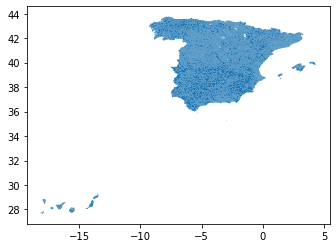

In [11]:
%%time
import shapely

rgda = get_cached_remote_zarr('nuts-2016-lau-2018', root = "copernicus-climate/european-nuts-lau-geometries.zarr")
# using set index and sel (crashes!)
#tst = rgda.set_index(x=['admin_level', 'iso3'])
#es = tst.sel(admin_level=4, iso3='ESP')

# using mask and where
mask = (rgda.admin_level == 4) & (rgda.iso3 == 'ESP') 
es = rgda.where(mask, drop=True)

# Convert to geodataframe
df = es.reset_coords().to_dataframe().dropna().reset_index()
geoms = [shapely.wkb.loads(g, hex=True) for g in es.geometry.values]
# Return as geopandas object, converting geometry to shapley objects
rgdf = gpd.GeoDataFrame(df, geometry = geoms)
rgdf.plot()

#gdf = get_gda_geoms('nuts-2016-lau-2018', select_by={'admin_level':2, 'iso3':'ESP'}, root = "copernicus-climate/european-nuts-lau-geometries.zarr")
#gdf.crs = 'EPSG:4326'
#gdf.plot()